对图像分类神经网络进行分析


In [ ]:
# 引入所需的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from torchvision import models
from sklearn.metrics import mutual_info_score
from torchvision import models

train_transform =transforms.Compose([
    #数据增广
    transforms.RandomResizedCrop(224),                                            # 随机裁剪
    transforms.RandomHorizontalFlip(),                                            # 水平随机反转
    transforms.RandomVerticalFlip(),                                              # 垂直随机反转
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),# 随机改变亮度、对比度、饱和度、色调
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# 载入caltech-101数据集
dataset_path = './caltech-101'
dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)

# 划分训练集和测试集
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
test_dataset.dataset.transform = test_transform


1、定义训练模型和测试的函数

In [20]:
# 训练模型
def train_model(num_epochs, model, criterion, optimizer, scheduler, train_loader, device):
    model.train()
    loss_list=[]
    acc_list=[]
    for epoch in range(num_epochs):
       running_loss = 0.0
       total = 0
       correct = 0
       for images, labels in train_loader:
           images, labels = images.to(device), labels.to(device)
           optimizer.zero_grad()             # 梯度清空
           outputs = model(images)           # 模型前向计算
           loss = criterion(outputs, labels) # 计算损失
           loss.backward()                   # 反向传播
           optimizer.step()                  # 执行参数更新
           running_loss += loss.item() * images.size(0)
           _, predicted = torch.max(outputs, 1)
           total += labels.size(0)
           correct += (predicted == labels).sum().item()
       scheduler.step()
       epoch_loss = running_loss / len(train_loader.dataset)
       epoch_accuracy = 100 * correct / total
       loss_list.append(epoch_loss)
       acc_list.append(epoch_accuracy)

    # 绘制准确率曲线
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), acc_list, marker='o', color='b', label='Train Accuracy')
    plt.title('model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), loss_list, marker='o', color='r', label='Train Loss')
    plt.title('model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 评估模型性能
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():  
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

2、训练模型并测试

d:\anaconda\envs\python_3.9\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\envs\python_3.9\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


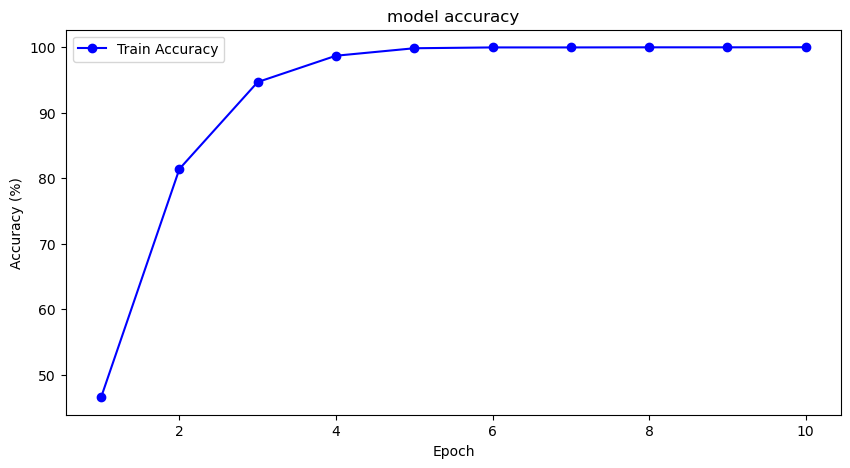

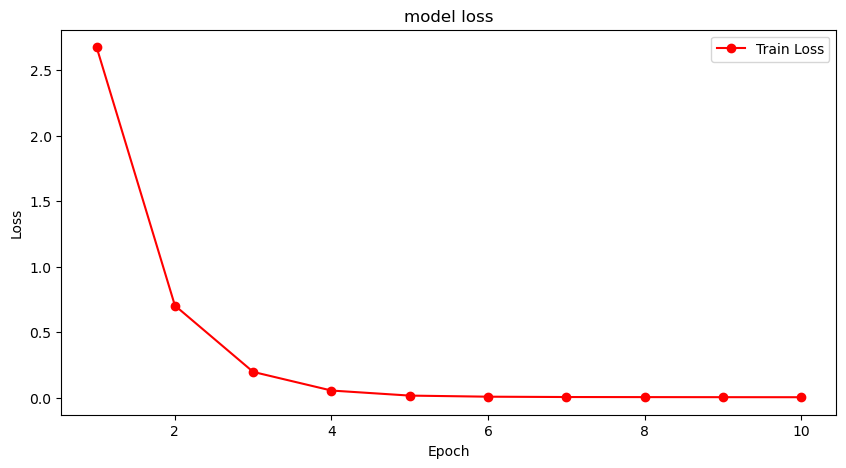

Test Accuracy: 90.38%


In [ ]:
# 封装数据集
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

# 设定参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 选用resnet18进行训练
model = models.resnet18(pretrained = True).to(device)
num_epochs = 10
criterion = nn.CrossEntropyLoss()   # 交叉熵函数
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=2e-4) # 随机梯度下降
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)       # 余弦退火

# 训练模型
train_model(num_epochs, model, criterion, optimizer, scheduler, train_loader, device)
# 评估模型
evaluate_model(model, test_loader, device)

3、分析神经元

In [22]:
# 提取某一层的神经元
def get_activations(layer, model, inputs, device):
    activations = []
    def hook(module, input, output):
        activations.append(output.detach().cpu().numpy())
    handle = layer.register_forward_hook(hook)
    _ = model(inputs.to(device))
    handle.remove()
    return np.concatenate(activations, axis=0)

3.1 对神经元的激活进行PCA降维处理

Activations_conv1 shape: (16, 512, 7, 7)


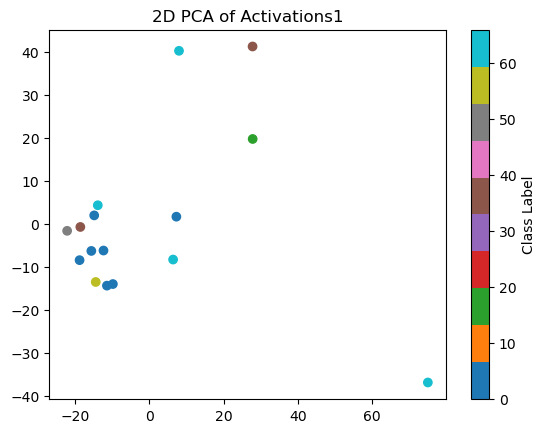

In [ ]:
# 从测试集获取数据
data_iter = iter(test_loader)
images, labels = next(data_iter)

# 获取layer4的第二层Residual Block的conv1的激活值
activations_conv1 = get_activations(model.layer4[1].conv1, model, images[:16], device)
print(f"Activations_conv1 shape: {activations_conv1.shape}") 

flat_activations1 = activations_conv1.reshape(activations_conv1.shape[0], -1)
# PCA降维
pca = PCA(n_components=2)
reduced_activations1 = pca.fit_transform(flat_activations1)
# 可视化
plt.scatter(reduced_activations1[:, 0], reduced_activations1[:, 1], c=labels[:16].numpy(), cmap='tab10')
plt.colorbar(label='Class Label')
plt.title('2D PCA of Activations1')
plt.show()

3.2 计算该层神经元与类别标签的mutual information

In [24]:
discretized_activations1 = (flat_activations1 > flat_activations1.mean(axis=0)).astype(int)    
mi_conv1 = []
for i in range(discretized_activations1.shape[1]):
    # 利用sklearn.metrics中的mutual_info_score函数计算
    mi_conv1.append(mutual_info_score(discretized_activations1[:, i], labels[:16].numpy()))
print(mi_conv1)
# 计算mutual information平均值
print(f"Average Mutual Information of Conv1: {np.mean(mi_conv1)}")

[0.4228704250474271, 0.5659678007211807, 0.3823935614446903, 0.422870425047427, 0.4544543674493905, 0.4544543674493905, 0.6853142072764582, 0.5659678007211807, 0.4544543674493905, 0.5017399679999678, 0.5422168316027044, 0.44662139416590324, 0.5623351446188081, 0.44662139416590324, 0.4466213941659033, 0.5659678007211808, 0.4544543674493905, 0.5659678007211807, 0.44662139416590324, 0.5659678007211807, 0.5422168316027044, 0.4466213941659033, 0.38239356144469017, 0.4466213941659033, 0.4544543674493905, 0.5422168316027044, 0.4544543674493905, 0.5659678007211807, 0.4544543674493905, 0.4544543674493905, 0.4544543674493905, 0.4544543674493905, 0.5659678007211807, 0.5738007740046679, 0.5017399679999678, 0.4466213941659033, 0.4466213941659033, 0.5738007740046679, 0.5659678007211807, 0.6853142072764581, 0.5659678007211807, 0.6931471805599454, 0.4544543674493905, 0.44662139416590324, 0.5422168316027045, 0.5659678007211808, 0.422870425047427, 0.5422168316027044, 0.4466213941659033, 0.57380077400466

3.3 计算信噪比

In [ ]:
# 定义信号和噪声
def s_n_r(activations, labels):
    signal = activations.mean(axis=0)   # 信号————均值
    noise = activations.std(axis=0)     # 噪声————标准差
    return signal, noise, (signal / noise).mean()

signal1, noise1, snr1 = s_n_r(flat_activations1, labels)
print('signal1:', signal1)
print('noise1:', noise1)
print('snr1:', snr1)


signal1: [-0.62979996 -0.8773143  -0.9188682  ... -0.79681075 -0.8613843
 -0.5183876 ]
noise1: [0.16652568 0.28086686 0.38487396 ... 0.2618404  0.26774338 0.18738006]
snr1: -2.0377119


4、其他层的神经元

4.1 与上述卷积层位于同一个Residual Block中的conv2

Activations_conv2 shape: (16, 512, 7, 7)


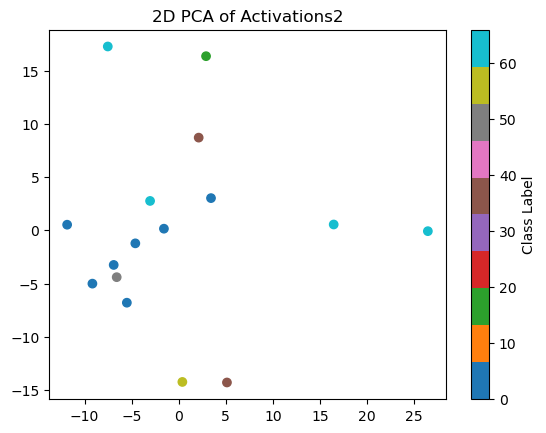

In [27]:
activations_conv2 = get_activations(model.layer4[1].conv2, model, images[:16], device)
print(f"Activations_conv2 shape: {activations_conv2.shape}") 

flat_activations2 = activations_conv2.reshape(activations_conv2.shape[0], -1)
# PCA可视化
reduced_activations2 = pca.fit_transform(flat_activations2)

plt.scatter(reduced_activations2[:, 0], reduced_activations2[:, 1], c=labels[:16].numpy(), cmap='tab10')
plt.colorbar(label='Class Label')
plt.title('2D PCA of Activations2')
plt.show()

In [ ]:
# mutual information
discretized_activations2 = (flat_activations2 > flat_activations2.mean(axis=0)).astype(int)

mi_conv2 = []
for i in range(discretized_activations2.shape[1]):
    mi_conv2.append(mutual_info_score(discretized_activations2[:, i], labels[:16].numpy()))
print(mi_conv2)
print(len(mi_conv2))
print(f"Average Mutual Information of Conv2: {np.mean(mi_conv2)}")

[0.5422168316027045, 0.5422168316027045, 0.5422168316027045, 0.4228704250474271, 0.4228704250474271, 0.4466213941659033, 0.4544543674493905, 0.4466213941659033, 0.5422168316027044, 0.4466213941659033, 0.4544543674493905, 0.4466213941659033, 0.4228704250474271, 0.4228704250474271, 0.4544543674493905, 0.4544543674493905, 0.4466213941659033, 0.422870425047427, 0.44662139416590324, 0.5659678007211808, 0.4228704250474271, 0.4228704250474271, 0.4466213941659033, 0.4544543674493905, 0.5659678007211807, 0.5738007740046679, 0.5738007740046679, 0.6931471805599454, 0.4466213941659033, 0.4466213941659033, 0.4228704250474271, 0.5422168316027045, 0.5017399679999676, 0.5659678007211808, 0.5659678007211808, 0.5738007740046679, 0.4544543674493905, 0.5738007740046679, 0.4228704250474271, 0.4466213941659033, 0.5738007740046679, 0.5659678007211808, 0.5738007740046679, 0.5659678007211807, 0.5738007740046679, 0.5738007740046679, 0.5738007740046679, 0.5659678007211808, 0.6853142072764582, 0.4466213941659033,

In [29]:
# snr
signal2, noise2, snr2 = s_n_r(flat_activations2, labels)
print('signal2:', signal2)
print('noise2:', noise2)
print('snr2:', snr2)

signal2: [ 0.05059155  0.10306472  0.06476925 ... -0.0543073  -0.06902334
 -0.05158799]
noise2: [0.09645176 0.1203557  0.1073921  ... 0.11040234 0.13069794 0.1058917 ]
snr2: -0.15316704


4.2 fc层

Activations_fc shape: (16, 1000)


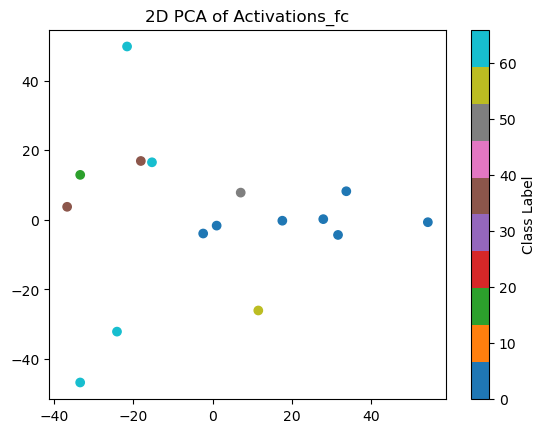

In [30]:
activations_fc = get_activations(model.fc, model, images[:16], device)
print(f"Activations_fc shape: {activations_fc.shape}") 

flat_activations_fc = activations_fc.reshape(activations_fc.shape[0], -1)
# PCA可视化
reduced_activations_fc = pca.fit_transform(flat_activations_fc)

plt.scatter(reduced_activations_fc[:, 0], reduced_activations_fc[:, 1], c=labels[:16].numpy(), cmap='tab10')
plt.colorbar(label='Class Label')
plt.title('2D PCA of Activations_fc')
plt.show()

In [33]:
# mutual information
discretized_activations_fc = (flat_activations_fc > flat_activations_fc.mean(axis=0)).astype(int)    
mi_fc = []
for i in range(discretized_activations_fc.shape[1]):
    mi_fc.append(mutual_info_score(discretized_activations_fc[:, i], labels[:16].numpy()))
print(mi_fc)
print(len(mi_fc))
print(f"Average Mutual Information of fc: {np.mean(mi_fc)}")

[0.5017399679999676, 0.4544543674493905, 0.6931471805599454, 0.5738007740046679, 0.38239356144469017, 0.6931471805599454, 0.5659678007211808, 0.4544543674493905, 0.5659678007211808, 0.4466213941659033, 0.6615632381579819, 0.6853142072764582, 0.5422168316027045, 0.5659678007211807, 0.5659678007211808, 0.4544543674493905, 0.6615632381579819, 0.5422168316027045, 0.6853142072764582, 0.4466213941659033, 0.4544543674493905, 0.5422168316027045, 0.5659678007211808, 0.6931471805599454, 0.6615632381579819, 0.5659678007211808, 0.6853142072764582, 0.4466213941659033, 0.5017399679999676, 0.5659678007211807, 0.5422168316027045, 0.4466213941659033, 0.6615632381579819, 0.4228704250474271, 0.4466213941659033, 0.621086374555245, 0.482577565177012, 0.4544543674493905, 0.6931471805599454, 0.6615632381579819, 0.5623351446188084, 0.4544543674493905, 0.3823935614446903, 0.5659678007211807, 0.6853142072764582, 0.5659678007211807, 0.4466213941659033, 0.5659678007211808, 0.6853142072764582, 0.5738007740046679, 

In [ ]:
# snr
signal_fc, noise_fc, snr_fc = s_n_r(flat_activations_fc, labels)

print('snr_fc:', snr_fc)

snr_fc: -0.11241855


4.3 layer1的第二层Residual Block的conv2

Activations_fc shape: (16, 64, 56, 56)


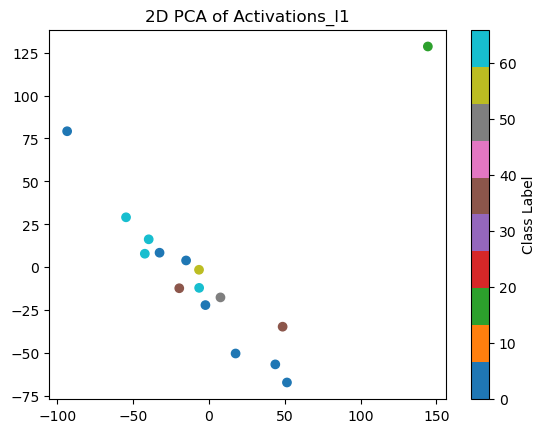

In [36]:
activations_l1 = get_activations(model.layer1[1].conv2, model, images[:16], device)
print(f"Activations_fc shape: {activations_l1.shape}") 

flat_activations_l1 = activations_l1.reshape(activations_l1.shape[0], -1)
# PCA可视化
reduced_activations_l1 = pca.fit_transform(flat_activations_l1)

plt.scatter(reduced_activations_l1[:, 0], reduced_activations_l1[:, 1], c=labels[:16].numpy(), cmap='tab10')
plt.colorbar(label='Class Label')
plt.title('2D PCA of Activations_l1')
plt.show()